In [2]:
%matplotlib inline
import os
import shutil
from time import gmtime, strftime
import numpy as np
from collections import OrderedDict
import logging
import nrrd
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import matplotlib.pylab as plt
logging.basicConfig(filename="logging_info_"+strftime("%Y-%m-%d %H:%M:%S", gmtime())+".log",level=logging.DEBUG, format='%(asctime)s %(message)s')

In [3]:
from PIL import Image

def plot_prediction(x_test, y_test, prediction, save=False):
    import matplotlib
    import matplotlib.pyplot as plt
    
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_3d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()


def crop_to_shape(data, shape):
    """
    Crops the array to the given image shape by removing the border (expects a tensor of shape [batches, nx, ny, nz, channels].
    
    :param data: the array to crop
    :param shape: the target shape
    """
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    offset2 = (data.shape[3] - shape[3])//2
    out = data[:, offset0:offset0+shape[1], offset1:offset1+shape[2], offset2:offset2+shape[3]]
    return out


def weight_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

def weight_variable_devonc(shape, stddev=0.1):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv3d(x, W,keep_prob_):
    conv_3d = tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='VALID')
    return tf.nn.dropout(conv_3d, keep_prob_)
#     return conv_3d

def deconv3d(x, W, stride=1):
    x_shape = tf.shape(x)
#     print(x.get_shape())
    output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3] * 2, x_shape[4] // 2])
#     print(output_shape.get_shape())
#     print(W.get_shape())
    return tf.nn.conv3d_transpose(x, W, output_shape, strides=[1, stride, stride, stride, 1], padding='VALID')

def max_pool(x,n):
    return tf.nn.max_pool3d(x, ksize=[1, n, n, n, 1], strides=[1, n, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2,  (x1_shape[3] - x2_shape[3]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], x2_shape[3], -1]
    x1_crop = tf.slice(x1, offsets, size)
    print(x1_crop.get_shape(), x2.get_shape())
    return tf.concat(4,[x1_crop, x2])

def pixel_wise_softmax(output_map):
    exponential_map = tf.exp(output_map)
    evidence = tf.add(exponential_map,tf.reverse(exponential_map,[False,False,False,True]))
    return tf.div(exponential_map,evidence, name="pixel_wise_softmax")

def pixel_wise_softmax_2(output_map):
    exponential_map = tf.exp(output_map)
    sum_exp = tf.reduce_sum(exponential_map, 4, keep_dims=True)
    tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, 1, tf.shape(output_map)[4]]))
    return tf.div(exponential_map,tensor_sum_exp)

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")
#     return tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(output_map), reduction_indices=[1]))

In [4]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2, summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,nz,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    nz = tf.shape(x)[3]
    
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,nz,channels]), name='input_reshape')
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    
    in_size = 1000    ##
    size = in_size
    # down layers
    with tf.name_scope('going_down'):
        for layer in range(0, layers):
            with tf.name_scope('layer_down_%d'%layer):
                features = 2**layer*features_root
                stddev = np.sqrt(2 / (filter_size**2 * features))    ##Why not filter_size**3
                if layer == 0:
                    w1 = weight_variable([filter_size, filter_size, filter_size, channels, features], stddev)
                else:
                    w1 = weight_variable([filter_size, filter_size, filter_size, features//2, features], stddev)

                w2 = weight_variable([filter_size, filter_size, filter_size, features, features], stddev)
                b1 = bias_variable([features])
                b2 = bias_variable([features])

                conv1 = conv3d(in_node, w1, keep_prob)
                tmp_h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(tmp_h_conv, w2, keep_prob)
                dw_h_convs[layer] = tf.nn.elu(conv2 + b2)

                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size -= 4    
                if layer < layers-1:
                    pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                    in_node = pools[layer]
                    size /= 2    
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    with tf.name_scope('going_up'):
        for layer in range(layers-2, -1, -1):      ## 1 0
            with tf.name_scope('layer_up_%d'%layer):
                features = 2**(layer+1)*features_root
                stddev = np.sqrt(2 / (filter_size**2 * features))

                wd = weight_variable_devonc([pool_size, pool_size, pool_size, features//2, features], stddev)
                bd = bias_variable([features//2])
                h_deconv = tf.nn.elu(deconv3d(in_node, wd, pool_size) + bd)
                h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)    
                deconv[layer] = h_deconv_concat

                w1 = weight_variable([filter_size, filter_size, filter_size, features, features//2], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features//2, features//2], stddev)
                b1 = bias_variable([features//2])
                b2 = bias_variable([features//2])

                conv1 = conv3d(h_deconv_concat, w1, keep_prob)
                h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(h_conv, w2, keep_prob)
                in_node = tf.nn.elu(conv2 + b2)
                up_h_convs[layer] = in_node

                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size *= 2
                size -= 4

    # Output Map
    with tf.name_scope('output_map'):
        weight = weight_variable([1, 1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class])
        conv = conv3d(in_node, weight, tf.constant(1.0))
        output_map = tf.nn.elu(conv + bias)
        up_h_convs["out"] = output_map

        if summaries:
    #         for i, (c1, c2) in enumerate(convs):
    #             tf.summary.image('summary_conv_%03d_01'%i, get_image_summary(c1))
    #             tf.summary.image('summary_conv_%03d_02'%i, get_image_summary(c2))

    #         for k in pools.keys():
    #             tf.summary.image('summary_pool_%03d'%k, get_image_summary(pools[k]))

    #         for k in deconv.keys():
    #             tf.summary.image('summary_deconv_concat_%03d'%k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%03d"%k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])

        variables = []
        for w1,w2 in weights:
            variables.append(w1)
            variables.append(w2)

        for b1,b2 in biases:
            variables.append(b1)
            variables.append(b2)

    
    return output_map, variables, int(in_size - size)


class Unet(object):
    """
    A unet implementation
    
    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """
    
    def __init__(self, channels=1, n_class=2, cost="dice_coefficient", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()
        
        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)
        
        self.x = tf.placeholder("float", shape=[None, None, None, None, channels], name='data')
        self.y = tf.placeholder("float", shape=[None, None, None, None,  n_class], name='target')
        self.keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)
        logging.info(logits.get_shape())
        logging.info(self.y.get_shape())
        
        self.logits = logits
        
        self.cost = self._get_cost(logits, cost, cost_kwargs)
        
        self.gradients_node = tf.gradients(self.cost, self.variables)
         
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y, [-1, n_class], name='cross_entro_label_reshape'),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class], name='px_logit_reshape')))
#         self.predicter = pixel_wise_softmax_2(logits)
        self.predicter = tf.nn.softmax(logits)
#         self.correct_pred = tf.equal(tf.(self.predicter, 4), tf.argmax(self.y, 4))
        self.correct_pred = tf.equal(self.predicter>0.5, self.y>0.5)
    
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are: 
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        with tf.name_scope('cost_function'):
            logging.info('*'*50)
            logging.info('getting cost')
            logging.info(logits.get_shape())
            logging.info(self.y.get_shape())
            flat_logits = tf.reshape(logits, [-1, self.n_class], name='flat_logits_reshape')
            flat_labels = tf.reshape(self.y, [-1, self.n_class], name='flat_labels_reshape')
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights, name='weightmap')
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map, name='weightloss')

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, 
                                                                                  labels=flat_labels))
            elif cost_name == "dice_coefficient":
                intersection = tf.reduce_sum(flat_logits * flat_labels, axis=1, keep_dims=True)
                mulLogits = tf.multiply(flat_logits, flat_logits, name='dicecoeff_logits_mul')
                mulLabels = tf.multiply(flat_labels, flat_labels, name='dicecoeff_labels_mul')
                union = tf.reduce_sum(mulLogits, axis=1, keep_dims=True) + tf.reduce_sum(mulLabels, axis=1, keep_dims=True)
                loss = 1 - tf.reduce_mean(2 * intersection/ (union))

            else:
                raise ValueError("Unknown cost function: "%cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)
            
        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, nz, channels]
        :returns prediction: The unet prediction Shape [n, px, py, pz, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})
            
        return prediction
    
    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param model_path: path to file system location
        """
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer
    """
    
    prediction_path = "prediction"
    verification_batch_size = 4
    
    def __init__(self, net, batch_size=1, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, 
                                                   **self.opt_kwargs).minimize(self.net.cost, 
                                                                                global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                     global_step=global_step)
        
        return optimizer
        
    def _initialize(self, training_iters, output_path, restore):
        global_step = tf.Variable(0)
        
        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))
        
        if self.net.summaries:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()        
        init = tf.global_variables_initializer()
        
        prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)
        
        if not restore:
            logging.info("Removing '{:}'".format(prediction_path))
            shutil.rmtree(prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)
        
        if not os.path.exists(prediction_path):
            logging.info("Allocating '{:}'".format(prediction_path))
            os.makedirs(prediction_path)
        
        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)
        
        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1, restore=False):
        """
        Lauches the training process
        
        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        """
        save_path = os.path.join(output_path, "model.cpkt")
        if epochs == 0:
            return save_path
        
        init = self._initialize(training_iters, output_path, restore)
        
        with tf.Session() as sess:
            sess.run(init)
            
            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)
            
            test_x, test_y = data_provider(self.verification_batch_size,"testing")
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")
            
            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")
            
            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size,"training")                     
                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
                                                      feed_dict={self.net.x: batch_x,
                                                                 self.net.y: crop_to_shape(batch_y, pred_shape),
                                                                 self.net.keep_prob: dropout})

                    if avg_gradients is None:
                        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
                    for i in range(len(gradients)):
                        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
                        
                    norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                    self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x, crop_to_shape(batch_y, pred_shape))
                        
                    total_loss += loss

                #print("epoch stats")
                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                #print("store predictions")
                self.store_prediction(sess, test_x, test_y, "epoch_%s"%epoch)
                    
                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            return save_path
        
    def store_prediction(self, sess, batch_x, batch_y, name):
        #logging.info("Storing prediction")
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x, 
                                                             self.net.y: batch_y, 
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape
        
        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x, 
                                                       self.net.y: crop_to_shape(batch_y, pred_shape), 
                                                       self.net.keep_prob: 1.})
        
        logging.info("Validation Error= %.1f, Validation Loss= %.4f" % (error_rate(prediction,crop_to_shape(batch_y, prediction.shape)),
                                                               loss))
              
#         img = combine_img_prediction(batch_x, batch_y, prediction)
#         save_image(img, "%s/%s.jpg"%(self.prediction_path, name))
        
        return pred_shape
    
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, Learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))
    
    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
#         logging.info(batch_x.shape)
        summary_str, loss, acc, predictions, logits = sess.run([self.summary_op, 
                                                        self.net.cost, 
                                                        self.net.accuracy, 
                                                        self.net.predicter,
                                                        self.net.logits], 
                                                        feed_dict={self.net.x: batch_x,
                                                                   self.net.y: batch_y,
                                                                   self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch Error= {:.1f}, LogitsMatrix= {}, Predictions= {}".format(step,
                                                                                                            loss,
                                                                                                            acc,
                                                                                                            error_rate(predictions, batch_y),
                                                                                                            logits[0][0][0][0],
                                                                                                            predictions[0][0][0][0]))


def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """
    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 4) == np.argmax(labels, 4)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3]))


def get_image_summary(img, idx=0):
    """
    Make an image summary for 5d tensor image with index idx
    """
    
    V = tf.slice(img, (0, 0, 0, 0, idx), (1, -1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255
    
    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    img_z = tf.shape(img)[3]
    V = tf.reshape(V, tf.stack((img_w, img_h, img_z, 1)))
    V = tf.transpose(V, (3, 0, 1, 2))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, img_z, 1)))
    return V

def loadCases(p):
    f = open(p)
    res = []
    for l in f:
        l = l[:-1]
        if l == "":
            break
        if l[-1] == '\r':
            l = l[:-1]
        res.append(l)
    return res

class BaseDataProvider(object):
    """
    Abstract base class for DataProvider implementation. Subclasses have to
    overwrite the `_next_data` method that load the next data and label array.
    This implementation automatically clips the data with the given min/max and
    normalizes the values to (0,1]. To change this behavoir the `_process_data`
    method can be overwritten. To enable some post processing such as data
    augmentation the `_post_process` method can be overwritten.
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    """
    
    channels = 1
    n_class = 2
    

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self,datafile):
        data, label = self._next_data(datafile)
            
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        
        train_data, labels = self._post_process(train_data, labels)
        
        nx = data.shape[0]
        ny = data.shape[1]
        nz = data.shape[2]

        return train_data.reshape(1, nx, ny, nz, self.channels), labels.reshape(1, nx, ny, nz, self.n_class),
    
    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[0]
            ny = label.shape[1]
            nz = label.shape[2]
            labels = np.zeros((nx, ny, nz, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        
        :param data: the data array
        :param labels: the label array
        """
        return data, labels
    
    def __call__(self, n, datafile = "training"):
        if datafile == "training":
            data, labels = self._load_data_and_label(self.training_data_files)
        elif datafile == "validation":
            data, labels = self._load_data_and_label(self.validation_data_files)
        elif datafile == "testing":
            data, labels = self._load_data_and_label(self.testing_data_files)
        else:
            raise NameError("No such datafile, datafile must be training, validation or testing")
        return data, labels
    


class ImageDataProvider(BaseDataProvider):
    """
    Generic data provider for images, supports gray scale and colored images.
    Assumes that the data images and label images are stored in the same folder
    and that the labels have a different file suffix 
    e.g. 'train/fish_1.tif' and 'train/fish_1_mask.tif'
    Usage:
    data_provider = ImageDataProvider("..fishes/train/*.tif")
        
    :param search_path: a glob search pattern to find all data and label images
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param data_suffix: suffix pattern for the data images. Default '.tif'
    :param mask_suffix: suffix pattern for the label images. Default '_mask.tif'
    
    """
    
    n_class = 2
    
    def __init__(self, search_path='', a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif'):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        
        self.file_idx = -1
        self.training_data_files, self.validation_data_files, self.testing_data_files = self._find_data_files() 
    
        assert len(self.training_data_files) > 0, "No training files"
        assert len(self.validation_data_files) > 0, "No validation files"
        assert len(self.testing_data_files) > 0, "No testing files"
        
        print("Number of training data used: %s" % len(self.training_data_files))
        print("Number of validation data used: %s" % len(self.validation_data_files))
        print("Number of testing data used: %s" % len(self.testing_data_files))
        
        self.channels = 1
        
        
    def _find_data_files(self):
        rootPath = "/home/ubuntu/ziyang/preprocessed_data/"
        dataPath = rootPath+"LabelMaps_1.00-1.00-1.00/"

        trainingCases = loadCases("train.txt")
        validationCases = loadCases("valid.txt")
        testingCases = loadCases("testing.txt")
        
        return [dataPath+name+'/case.nrrd' for name in trainingCases],[dataPath+name+'/case.nrrd' for name in validationCases],[dataPath+name+'/case.nrrd' for name in testingCases]
    
    
    def _load_file(self, path, dtype=np.float32):
        tile = 148
        zer = np.zeros((tile,tile,tile), dtype=dtype)
        data = nrrd.read(path)[0].astype(dtype)
        xmin = min(data.shape[0], tile)
        ymin = min(data.shape[1], tile)
        zmin = min(data.shape[2], tile)
        zer[:xmin, :ymin, :zmin] = data[:xmin, :ymin, :zmin]
        return zer

    def _cycle_file(self,datafile):
        self.file_idx += 1
        if self.file_idx >= len(datafile):
            self.file_idx = 0 
        
    def _next_data(self,datafile):
        self._cycle_file(datafile)
        image_name = datafile[self.file_idx]
        label_name = image_name.replace('case', 'labelmap')
        
        logging.info("Case: {}".format(image_name))
             
        img = self._load_file(image_name, np.float32)
        label = self._load_file(label_name, np.bool)
    
        return img,label

## setting up the unet

In [5]:
net = Unet(channels=1, 
           n_class=2, 
           layers=3, 
           features_root=16, summaries=True
          )

(?, ?, ?, ?, ?) (?, ?, ?, ?, 32)
(?, ?, ?, ?, ?) (?, ?, ?, ?, 16)


## training

In [ ]:
data_provider = ImageDataProvider()

trainer = Trainer(net, batch_size=1, optimizer="momentum", opt_kwargs=dict(momentum=0.2))
path = trainer.train(data_provider, "./unet_trained", 
                     training_iters=37, 
                     epochs=3, 
                     dropout=0.5, 
                     display_step=1)

Number of training data used: 37
Number of validation data used: 21
Number of testing data used: 3


In [21]:
img = ImageDataProvider()
img._load_data_and_label(img.testing_data_files)[0].shape

Number of training data used: 37
Number of validation data used: 21
Number of testing data used: 3


(1, 148, 148, 148, 1)

In [23]:
prediction = net.predict("./unet_trained/model.cpkt", img._load_data_and_label(img.testing_data_files)[0])

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./unet_trained/model.cpkt
	 [[Node: save_1/RestoreV2_22 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_22/tensor_names, save_1/RestoreV2_22/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_31/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_82_save_1/RestoreV2_31", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2_22', defined at:
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-835ef0f1e892>", line 1, in <module>
    prediction = net.predict("./unet_trained/model.cpkt", img._load_data_and_label(img.testing_data_files)[0])
  File "<ipython-input-18-13b19f76c0d2>", line 242, in predict
    self.restore(sess, model_path)
  File "<ipython-input-18-13b19f76c0d2>", line 269, in restore
    saver = tf.train.Saver()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ubuntu/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./unet_trained/model.cpkt
	 [[Node: save_1/RestoreV2_22 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2_22/tensor_names, save_1/RestoreV2_22/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_31/_15 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_82_save_1/RestoreV2_31", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [27]:
print(prediction[0])
res = prediction[0][:,:,:,1]

[[[[ 0.73093891  0.26906106]
   [ 0.7308839   0.2691161 ]
   [ 0.73088318  0.26911682]
   ..., 
   [ 0.73077565  0.26922438]
   [ 0.73091733  0.2690827 ]
   [ 0.73082525  0.26917472]]

  [[ 0.73096478  0.26903522]
   [ 0.73089808  0.26910192]
   [ 0.73095542  0.26904455]
   ..., 
   [ 0.73089486  0.2691052 ]
   [ 0.73080003  0.26919997]
   [ 0.73092186  0.2690782 ]]

  [[ 0.73093599  0.26906404]
   [ 0.73097593  0.2690241 ]
   [ 0.73092645  0.26907358]
   ..., 
   [ 0.73082083  0.26917917]
   [ 0.73088658  0.26911342]
   [ 0.73086882  0.26913115]]

  ..., 
  [[ 0.7309624   0.26903754]
   [ 0.73090464  0.26909533]
   [ 0.73095667  0.26904327]
   ..., 
   [ 0.73096406  0.26903594]
   [ 0.73097932  0.26902071]
   [ 0.73097736  0.26902264]]

  [[ 0.7309435   0.26905653]
   [ 0.73096901  0.26903096]
   [ 0.73093706  0.26906288]
   ..., 
   [ 0.73095149  0.2690486 ]
   [ 0.73100901  0.26899105]
   [ 0.73093206  0.26906794]]

  [[ 0.73086929  0.26913068]
   [ 0.7309255   0.2690745 ]
   [ 0.73

In [13]:
rres = np.where(res>0.2)
print(len(rres[0]))

1259712


<IPython.core.display.Javascript object>


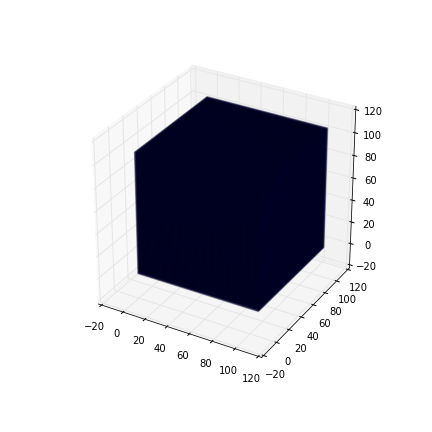

In [14]:
%matplotlib notebook
xs,ys,zs = rres
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=1)
plt.show()

In [19]:
train = loadCases('train.txt')
print(train)

['007', '008', '012', '014', '016', '021', '022', '023', '024', '025', '026', '027', '029', '030', '031', '033', '034', '035', '037', '038', '039', '040', '041', '042', '044', '045', '048', '049', '050', '053', '056', '058', '059', '060', '063', '064', '069']
